In [1]:
# The data being used is the Intel Image classification dataset
# which consists of images of 6 types of land areas

In [1]:
# 6. Code
# 引入包

import numpy as np
import pandas as pd
import os
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

from tensorflow.keras.layers import Input
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

2024-04-25 08:33:03.075580: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'] 

In [3]:
# 构建训练数据集
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   zoom_range=0.1,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=False)

training_set = train_datagen.flow_from_directory('dataset/seg_train/seg_train/',
                                                target_size=(224, 224),
                                                batch_size=32,
                                                class_mode='categorical',
                                                classes=class_names)

Found 14034 images belonging to 6 classes.


In [4]:
# 读取test_set
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory('dataset/seg_test/seg_test/',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='categorical',
                                           classes=class_names,
                                           shuffle=False)

Found 3000 images belonging to 6 classes.


In [5]:
import random as rn
# set random seed
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

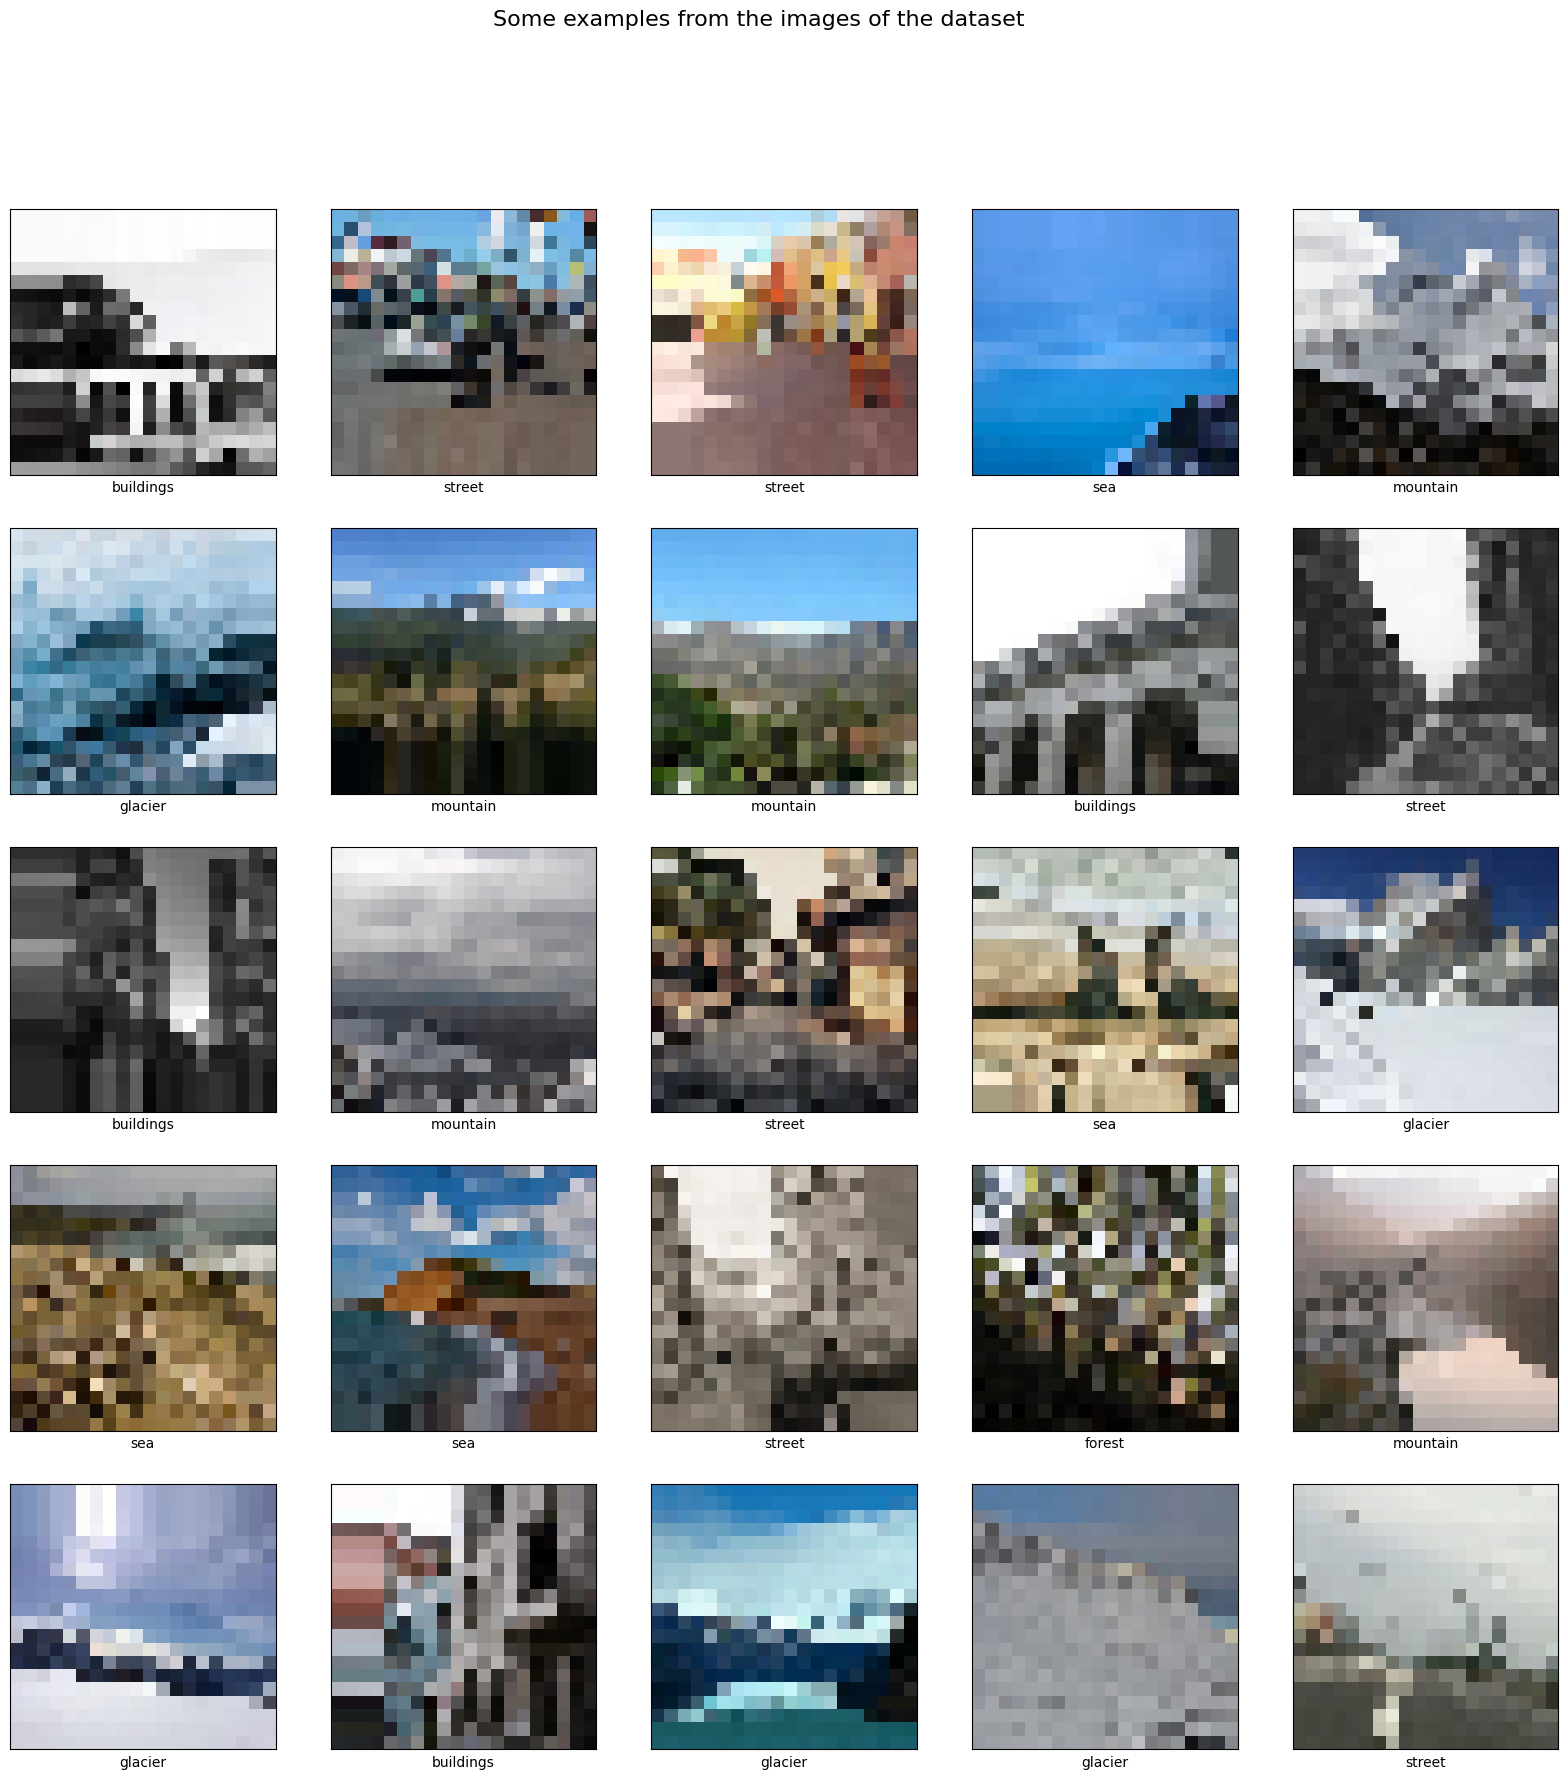

In [6]:
import cv2
# 任选25张图片做 5行5列的显示
# 去掉resize，可以得到比较好看的图

def display_images(class_names, images, labels):
    '''
        Display 25 images from the images array with its corresponding labels
    '''
    figsize = (20, 20)
    fig = plt.figure(figsize=figsize)
    fig.suptitle('Some examples from the images of the dataset', fontsize=16)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        image = cv2.resize(images[i], figsize)
        plt.imshow(image)
        label_idx = int(tf.argmax(labels[i], axis=-1))
        plt.xlabel(class_names[label_idx])
    plt.show()

batch_x, batch_y = next(training_set)
display_images(class_names, batch_x[:25], batch_y[:25])
    

In [7]:
# 不要VGG16的top
# VGG16 前面一直到 -4层，不训练
# 后面4层训练，
# 训练完之后给加上一个自己的卷积和输出层
from keras.applications.vgg16 import VGG16 
baseModel = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# baseModel.summary()

In [8]:
headModel = baseModel.output
headModel = Conv2D(64, (3, 3), activation='relu', padding='same')(headModel)
headModel = MaxPooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dense(6, activation='softmax')(headModel)

# Place the head FC model on top of the baseModel, 
# This will become the actual model we will train
new_model = Model(inputs=baseModel.input, outputs=headModel)

In [9]:
# 不更新basemodel的权重，网络太大了，更新起来比较耗算力
# loop over all layers in the base model and freezed them so they will not be 
# updated during the first training process
for layer in baseModel.layers[:-4]:
    layer.trainable = False

In [10]:
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
total_train_samples = len(training_set.filenames)
total_test_samples = len(test_set.filenames)
print(f'total train samples: {total_train_samples}, total test samples: {total_test_samples}')

total train samples: 14034, total test samples: 3000


In [13]:
BS = 32
EPOCHES = 4
# fit 模型，包括增强后的图像数据
# train accuracy 和 validation accuray的值一样 或者类似的时候，比较好，说明bias比较正常，
# 如果 validation accuracy 比 train accuracy要高， 说明bias较大，出问题了

# 定义一个回调函数来保存验证集上表现最好的模型
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Train the head of the network
print('[INFO] training head...')
history = new_model.fit(
    training_set,
    steps_per_epoch=total_train_samples  // BS,
    validation_data=test_set,
    validation_steps=total_test_samples // BS,
    epochs=EPOCHES,
    callbacks=[checkpoint_callback]
)

[INFO] training head...
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6615 - loss: 0.8924 
Epoch 1: val_loss improved from inf to 0.39397, saving model to best_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 5337s 12s/step - accuracy: 0.6617 - loss: 0.8918 - val_accuracy: 0.8690 - val_loss: 0.3940
Epoch 2/4
  1/438 ━━━━━━━━━━━━━━━━━━━━ 1:23:17 11s/step - accuracy: 0.8438 - loss: 0.4387

2024-04-25 02:11:28.239111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.39397 to 0.17410, saving model to best_model.keras


2024-04-25 02:11:35.964778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


438/438 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.8438 - loss: 0.4387 - val_accuracy: 0.9583 - val_loss: 0.1741
Epoch 3/4
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8574 - loss: 0.4005 
Epoch 3: val_loss did not improve from 0.17410
438/438 ━━━━━━━━━━━━━━━━━━━━ 5435s 12s/step - accuracy: 0.8574 - loss: 0.4005 - val_accuracy: 0.8881 - val_loss: 0.3034
Epoch 4/4
  1/438 ━━━━━━━━━━━━━━━━━━━━ 1:08:09 9s/step - accuracy: 0.9375 - loss: 0.1885

2024-04-25 03:42:23.089418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_loss improved from 0.17410 to 0.12887, saving model to best_model.keras


2024-04-25 03:42:29.013507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


438/438 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9375 - loss: 0.1885 - val_accuracy: 0.9583 - val_loss: 0.1289


In [16]:
def plot_accuracy_loss(history):
    '''
        Plot the accuracy and the loss during the training of the nn
    '''
    fig = plt.figure(figsize=(10, 5))
    # plot accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], 'bo--', label='acc')
    plt.plot(history.history['val_accuracy'], 'ro--', label='val_acc')
    plt.title('train_acc vs val_acc')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend()

    # plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], 'bo--', label='loss')
    plt.plot(history.history['val_loss'], 'ro--', label='val_loss')
    plt.title('train_loss vs val_loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()


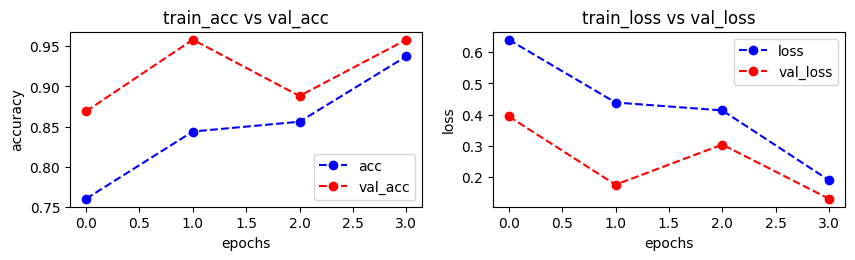

In [17]:
plot_accuracy_loss(history)

In [6]:
new_model = tf.keras.models.load_model('./best_model.keras')
# 查看model的架构
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,982,356 (114.37 MB)

 Trainable params: 7,449,030 (28.42 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 14,898,062 (56.83 MB)

In [9]:
steps = int(np.ceil(total_test_samples / 32))  # 假设批次大小为 32 

In [25]:
# 算精度
# 评估模型性能  
# 当前模型并没有见过这个数据集

loss, accuracy = new_model.evaluate(test_set, steps=steps)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

94
94/94 ━━━━━━━━━━━━━━━━━━━━ 821s 9s/step - accuracy: 0.8851 - loss: 0.2991
Test loss: 0.3059750497341156, Test accuracy: 0.8863333463668823


In [10]:
from sklearn.metrics import classification_report, accuracy_score
import os
import cv2

IMAGE_SIZE = (224, 224)
# Loading the data
def load_data():
    DIRECTORY = r'./dataset/seg_test'
    CATEGORY = ['seg_test']
    output = []
    for category in CATEGORY:
        path = os.path.join(DIRECTORY, category)
        print(path)
        images = []
        labels = []
        print('Loading {}'.format(category))
        for folder in os.listdir(path):
            # Label是class 对应的数字
            label = training_set.class_indices[folder]
            # Iterate through each image in our folder
            for file in os.listdir(os.path.join(path, folder)):
                # Get the path name of the image
                img_path = os.path.join(os.path.join(path, folder), file)
                # Open and resize the image
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                images.append(image)
                labels.append(label)
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        output.append(images)
        output.append(labels)
    return output 

In [11]:
test_images, test_labels = load_data()

./dataset/seg_test/seg_test
Loading seg_test


In [12]:
# 将标签列表转换为NumPy数组（如果需要）  
y_test = test_labels
predict = new_model.predict(test_set, steps=steps)
y_preds = np.argmax(predict, axis=-1)
# 算精度
print('Accuracy: {}'.format(accuracy_score(y_test, y_preds)))
# 查看classification_report
print(classification_report(y_test, y_preds))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 804s 9s/step
Accuracy: 0.8863333333333333
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       437
           1       0.99      0.96      0.98       474
           2       0.80      0.87      0.84       553
           3       0.89      0.80      0.84       525
           4       0.92      0.88      0.90       510
           5       0.89      0.89      0.89       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000

